### How to use 'stackforge' (preliminary name)


In [1]:
import stackforge
import numpy as np
import matplotlib.pyplot as plt
import h5py

from plottery.plotutils import update_rcParams
update_rcParams() #fancy plots!

Define a `basePath` for illustris or illustring TNG simulations, it is required for `illutris_python` package 

In [2]:
basePath = "/home/tnguser/sims.TNG/TNG100-3/output/"

The `stackforge.halo` load a single halo/subHalo from a simulation. For the moment the only availables simulations are illustris and illustris-TNG. If the argument `sim` is `TNG` or `Illustris`, is neccesary pass as aditional arguments a `basePath`, a `snapNum` or `redshift`, and a `haloID`. 

In [3]:
h = stackforge.halo(sim = "TNG", basePath = basePath, snapNum = 99, haloID = 0) 

To generate 1halo profiles is necessary run `halo.generate_profiles`, it receive a projection mode that can be `2d` or `3d`.  To generate 1halo + 2halo (total) profiles a full snapshot must be passed as `snap` argument or is possible set `use_snap=True`.


/home/tnguser/examples/stackforge/src/helpers/binner.py:32: RuntimeWarning: invalid value encountered in divide
  prof = sum_w / counts
/home/tnguser/examples/stackforge/src/helpers/misc.py:97: RuntimeWarning: divide by zero encountered in log10
  temp = np.log10(temp)
/home/tnguser/examples/stackforge/src/stackforge.py:280: RuntimeWarning: invalid value encountered in multiply
  tSZ = ne * T
/home/tnguser/examples/stackforge/src/stackforge.py:281: RuntimeWarning: invalid value encountered in multiply
  rSZ = ne * T**2
/home/tnguser/examples/stackforge/src/helpers/binner.py:95: RuntimeWarning: invalid value encountered in divide
  prof = sum_w / counts


[Text(0.5, 0, 'R (ckpc)'), Text(0, 0.5, 'electron number density')]

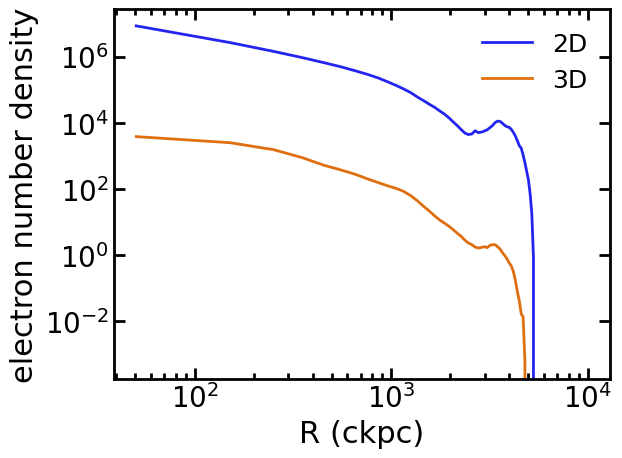

In [4]:
R = np.linspace(0, 1e4, 100)
h.generate_profiles(R, projection = "2d", use_area = True, triax = True)
h.generate_profiles(R, projection = "3d", use_area = True, triax = True)
ne2d = h.profiles2D[0] #index 0 is for electron number density
ne3d = h.profiles3D[0]
fig, ax = plt.subplots()
ax.loglog(h.R_centers, ne2d, label = "2D")
ax.loglog(h.R_centers, ne3d, label = "3D")
ax.legend(frameon = False)
ax.set(xlabel = "R (ckpc)", ylabel = "electron number density")

To separate into 1h and 2h term, is possible load an entire snapshot given a redshift using `load_snap` and run `generate_profles` with the arguments `snap` and `use_snap = True`, it produces a profile considering *bound* and *unbound* particles to the halo.

In [5]:
z = 0.
snap = stackforge.load_snap(basePath, redshift = z)

In [6]:
h.generate_profiles(R, projection = "3d", use_snap = True, snap = snap, remove_h=True)

[Text(0.5, 0, 'R (ckpc)'), Text(0, 0.5, 'electron number density')]

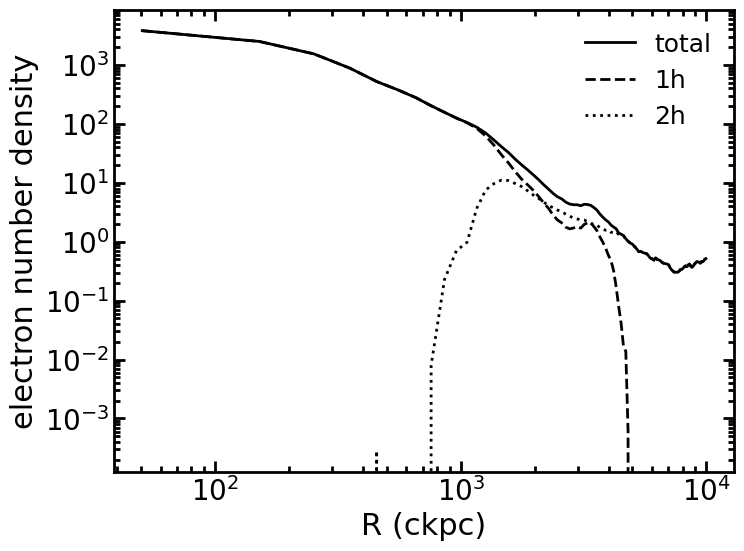

In [7]:
ne3d_total = h.profiles3D[0]
ne3d_2h = ne3d_total - ne3d
fig, ax = plt.subplots(figsize = (8, 6))
ax.loglog(h.R_centers, ne3d_total, color = "black", label = "total", ls = "solid")
ax.loglog(h.R_centers, ne3d, label = "1h", color = "black", ls = "--")
ax.loglog(h.R_centers, ne3d_2h, label = "2h", color = "black", ls = "dotted")
ax.legend(frameon = False)
ax.set(xlabel = "R (ckpc)", ylabel = "electron number density")

To load a multiple halos at the same time is neccesary to use `stack` instance. If `sim='Illustris'` or `sim=TNG` a basePath must be pass. To generate 1h and 2h halo profiles of all the halos contained in stack run `compute_1h2hprofiles`, it receive a radius in kpc. Is possible intepretate the radius as physical or comoving by setting `comoving` to `False` or `True`. `remove_h=True` remove the $h$ factor to all properties. `save` store the current stack as a `.h5` file with the name `profiles_z=redshift.h5`.

In [8]:
basePath = "/home/tnguser/sims.TNG/TNG100-3/output/"
redshifts = [0, 0.5, 1]
haloIDs = [i for i in range(30)] #most massive halos
R = np.linspace(0, 15000, 100)
for z in redshifts:
    snap = stackforge.load_snap(basePath, redshift = z)
    s = stackforge.stack(sim = "TNG", basePath = basePath, haloIDs = haloIDs, redshift=z, snap = snap)
    s.compute_1h2hprofiles(R, comoving = True, remove_h = True)
    s.save()

Processing halos: 100%|██████████| 30/30 [48:12<00:00, 96.40s/it]    


In [2]:
redshifts = ["0.0", "0.5", "1.0"]
hfiles = [h5py.File(f"profiles_z={z}.h5", "r") for z in redshifts]
profiles1h = np.array([h["profiles1h"] for h in hfiles])
profiles2h = np.array([h["profiles2h"] for h in hfiles])

h = 0.67

Masses = (np.array([h["Masses"][:]/h["h"] for h in hfiles]) * 1e10).flatten()
RTopHat = (np.array([h["RTopHat"][:] for h in hfiles]))
cmean = np.array([np.array(h["cmean_ne"]) for h in hfiles])/h**2
profiles1h.shape

print(hfiles[0].keys())
[h.close() for h in hfiles]

<KeysViewHDF5 ['BHMass', 'BHMdot', 'BoxSize', 'GasMetalFraction', 'GasMetallicity', 'M200c', 'M200m', 'M500c', 'MTopHat', 'Masses', 'R200c', 'R200m', 'R500c', 'RTopHat', 'SNR', 'StarMetallicity', 'Vel', 'basePath', 'cBoxSize', 'cmean_ne', 'h', 'haloIDs', 'mean_ne', 'profiles1h', 'profiles2h', 'redshift', 'snapNum']>


[None, None, None]



`profiles1h` and `profiles2h` contain 1h and 2h term for each halo, respectively, which have shape `(nredshifts, nhalos, profile_type, Rradius)`. profiles_type are

* electron number density: index 0.
* electron pressure  $n_e T$: index 1.
* relativistic tSZ $n_e T^2$: index 2.
* electron abundance: index 3.
* temperature: index 4.

An estimation of the mean background density of each box at the specific redshift can be found as `cmean_ne` in comoving length (constant) and `mean_ne` in physical units. The unists of `mean_ne` and `cmean_ne` are $[m^{-3}h^{-2}]$

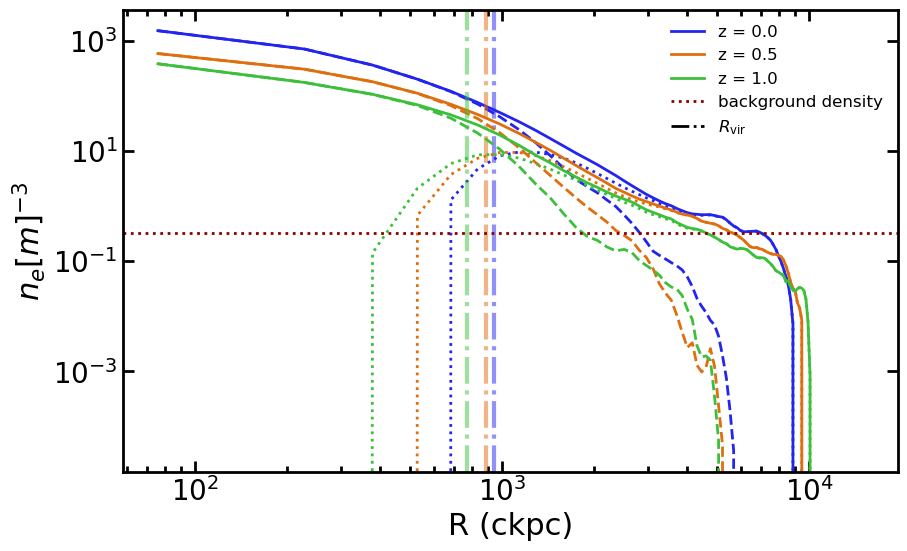

In [3]:
ne_1h = profiles1h[:,:,0,:]
ne_2h = profiles2h[:,:,0,:]

mean1h = np.mean(ne_1h, axis = 1)
mean2h = np.mean(ne_2h, axis = 1)

R = np.linspace(0, 15000, 100)
Rbins = []
for i in range(len(R) - 1):
    Rbins.append((R[i]+R[i + 1])/2)
fig, ax = plt.subplots(figsize = (10,6))
for i in range(len(mean1h)):
    line, = ax.plot(Rbins, mean1h[i], ls = "--")
    ax.plot(Rbins, mean2h[i] - cmean[i], ls = "dotted", color = line.get_color())
    ax.plot(Rbins, (mean2h + mean1h)[i] - cmean[i], color = line.get_color(), label = f"z = {redshifts[i]}")
    Rtop = np.mean(RTopHat[i])
    ax.axvline(Rtop, color = line.get_color(), ls = "-.", lw = 3, alpha = 0.5)
ax.axhline(cmean[0], ls = "dotted", color = "darkred", label = "background density")
ax.plot([],[], ls = "-.", label = "$R_{\mathrm{vir}}$", color = "black")
ax.set(yscale = "log", xscale = "log", ylabel = "$n_e [m]^{-3}$", xlabel = "R (ckpc)")
ax.legend(frameon = False, fontsize = 12)
fig.savefig("profiles_vs_redshift.png")

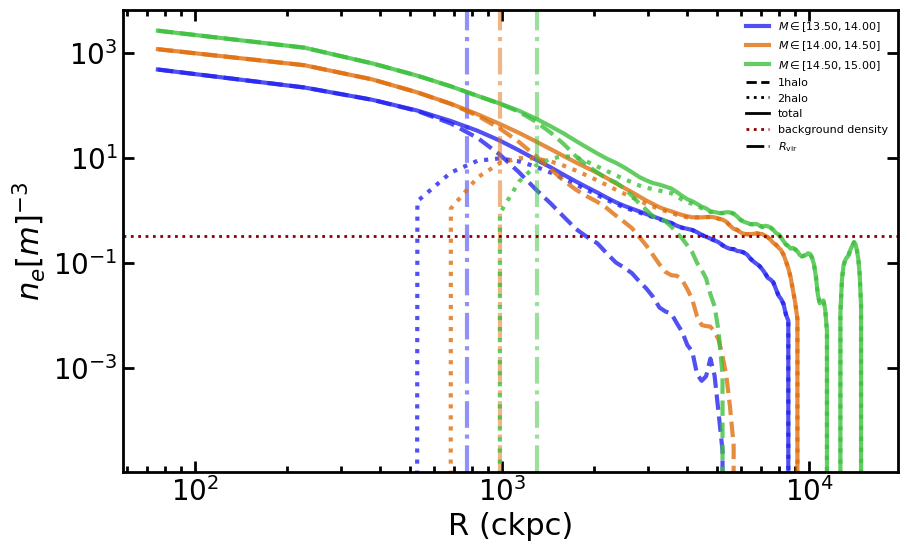

In [4]:
Mbins = np.logspace(13.5, 15, 4)
flatten_profiles1h = np.reshape(profiles1h, (len(profiles1h)*len(profiles1h[1]), 5 ,-1))
flatten_profiles2h = np.reshape(profiles2h, np.shape(flatten_profiles1h))
flatten_RTopHat = RTopHat.flatten()
fig, ax = plt.subplots(figsize = (10,6))

for i in range(len(Mbins) - 1):
    Mmin = Mbins[i]
    Mmax = Mbins[i + 1]
    mask = np.where((Masses >= Mmin) & (Masses < Mmax))
    
    p1h = flatten_profiles1h[mask][:,0,:]
    p2h = flatten_profiles2h[mask][:,0,:]
    p1hmean = np.mean(p1h, axis = 0)
    p2hmean = np.mean(p2h, axis = 0)
    pmean = p1hmean + p2hmean
    Rtop = np.mean(flatten_RTopHat[mask])
    line, = ax.loglog(Rbins, pmean - cmean[0], lw = 3, alpha = 0.8, label = "$M \in [%.2f,%.2f]$" % (np.log10(Mmin), np.log10(Mmax)))
    ax.loglog(Rbins, p1hmean, lw = 3, alpha = 0.8, color = line.get_color(), ls = "--")
    ax.loglog(Rbins, p2hmean - cmean[0], lw = 3, alpha = 0.8, color = line.get_color(), ls = "dotted")
    ax.axvline(Rtop, color = line.get_color(), ls = "-.", lw = 3, alpha = 0.5)
ax.plot([],[], label = "1halo", ls = "--", color = "black")
ax.plot([],[], label = "2halo", ls = "dotted", color = "black")
ax.plot([],[], label = "total", color = "black")
ax.axhline(cmean[0], ls = "dotted", color = "darkred", label = "background density")
ax.set(yscale = "log", xscale = "log", ylabel = "$n_e [m]^{-3}$", xlabel = "R (ckpc)")
ax.plot([],[], ls = "-.", label = "$R_{\mathrm{vir}}$", color = "black")
ax.legend(frameon = False, fontsize = 8)
fig.savefig("profiles_vs_mass.png")

Let's fit a beta profile to our data using the `sampler` instance. `sampler` allows to fit data given a set of observed data vector $y$, evaluated at $x$, with covariance $C$. `sampler` accepts a list of `prior` for each parameter, in the form of a list with form `[prior_func1|arg1,arg2..., prior_funcn|args1,args2...]`, where `prior_func_i` are functions with the form `def prior(theta, arg1, arg2...)`, where theta is the respective parameter. `prior_func_i` are functions that must contained  the `priors_dir=priors.py` file. Model must be a function contained in the `models_dir=models.py` file with syntax `def func(x, params)`, with `params` a vector with the same lenght than `priors`. 

$$
n_e(r) = \frac{P_0}{(r/r_s)^{\gamma}\times\left[1 + (r/r_s)^{\alpha}\right]^{\frac{\beta - \gamma}{\alpha}}}
$$

$$
n_e(r) = n_{e,0}\left[1 + \left(\frac{r}{r_s}\right)^2\right]^{-\frac{3}{2}\beta}
$$

In [22]:
priors = [
    "flat_prior|-10,10",
    "t_student_prior_truncated|1,0,-15,15",
    "t_student_prior_truncated|1,0,-15,15",
    "t_student_prior_truncated|1,0,-15,15",
    "flat_prior|-10, 10",
    "flat_prior|-3, 2"
         ]
model = "gnfw"
spr = stackforge.sampler(Rbins, mean1h[0], priors, model)
spr.run(nsteps = 35000, nwalkers = 32,  ncores=1)

/home/tnguser/examples/stackforge/src/stackforge.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  dtype.append(("chi2", np.dtype((np.float64, 1))))
  6%|▌         | 2004/35000 [03:50<1:03:17,  8.69it/s]

KeyboardInterrupt



In [7]:
def beta(r, params):
    ne0, rs, beta = params
    ne0 = 10**ne0
    rs = 10**rs
    return ne0*(1 + (r/rs)**2)**(-3/2*beta)
def gnfw(r, params):
    p0, gamma, beta, alpha, rs = params
    rs = 10**rs
    p0 = 10**p0
    x = r/rs
    prof = p0/(x**gamma * (1 + x**alpha)**((beta - gamma)/alpha))
    return prof


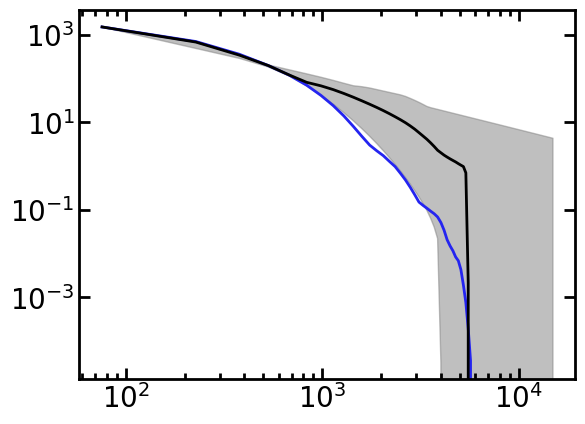

In [13]:
blobs, chain = spr.load_chain()

signal = blobs["signal"]
chi2 = blobs["chi2"]
signal = np.reshape(signal, (np.shape(chain)[0], -1))

m16, m, m84 = np.percentile(signal, [16, 50, 84], axis = 0)

fig, ax = plt.subplots()
ax.loglog(Rbins, mean1h[0])
ax.loglog(Rbins,m, color = "black")
ax.fill_between(Rbins, m16, m84, color = "grey", alpha = 0.5)

In [14]:
import corner

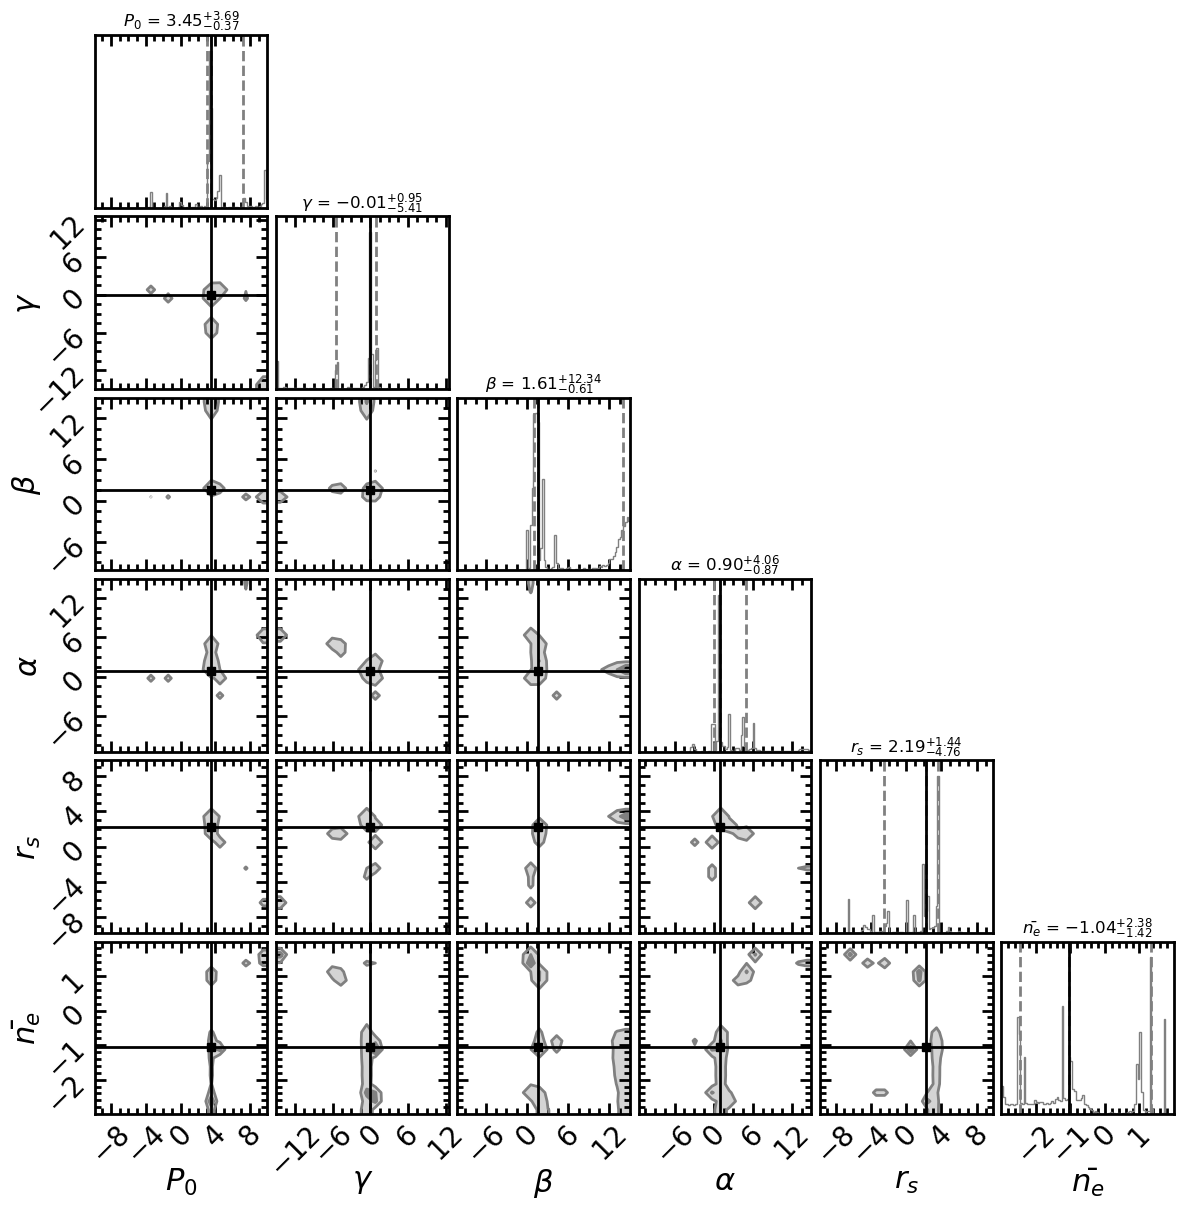

In [21]:
fig = plt.figure(figsize = (12,12))
labels = [r"$P_0$", r"$\gamma$", r"$\beta$",r"$\alpha$",r"$r_s$",r"$\bar{n_e}$"]
quantiles = [0.16, 0.5, 0.84]
levels = (1-np.exp(-0.5), 1-np.exp(-2))
truths = np.median(chain, axis = 0)

corner_plot = corner.corner(
        chain,
        fig = fig,
        labels = labels,
        quantiles = quantiles,
        show_titles = True,
        levels = levels,
        truths = truths,
        truth_color = "black",
        plot_density = True,
        no_fill_contours = True,
        plot_datapoints = False,
        fill_contours = True,
        hist_bin_factor= 5,
        n_max_ticks = 5,
        color = "grey",
        title_kwargs = dict(fontsize = 12)
    )